## 0. Importing Hannes Functions

In [1]:
import pandas as pd
import numpy as np
import csv

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
#nltk.download('stopwords')
from nltk.corpus import stopwords

#!python -m spacy download en_core_web_sm
import spacy
sp = spacy.load('en_core_web_sm')

import re


from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD

import os

import re



from tqdm import tqdm
tqdm.pandas()


#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

In [3]:
#additional functions

def strip(word):
    mod_string = re.sub(r'\W+', '', word)
    return mod_string

#the following leaves in place two or more capital letters in a row
#will be ignored when using standard stemming
def abbr_or_lower(word):
    if re.match('([A-Z]+[a-z]*){2,}', word):
        return word
    else:
        return word.lower()

#modular pipeline for stemming, lemmatizing and lowercasing
#note this is NOT lemmatizing using grammar pos
    
def tokenize(text, modulation):
    if modulation<2:
        tokens = re.split(r'\W+', text)
        stems = []
        # filter out any tokens not containing letters (e.g., numeric tokens, raw punctuation)
        for token in tokens:
            lowers=abbr_or_lower(token)
            if lowers not in stop_words:
                if re.search('[a-zA-Z]', lowers):
                    if modulation==0:
                        stems.append(lowers)
                    if modulation==1:
                        stems.append(porter.stem(lowers))
    else:
        sp_text=sp(text)
        stems = []
        lemmatized_text=[]
        for word in sp_text:
            lemmatized_text.append(word.lemma_)
        stems = [abbr_or_lower(strip(w)) for w in lemmatized_text if (abbr_or_lower(strip(w))) and (abbr_or_lower(strip(w)) not in stop_words)]
    return " ".join(stems)

## 1. Session 8 code - This will do pre-preprocessing with td-idf and SVD. I will try with European Commission today.

In [5]:
#loading the data

path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename ="data/thewhitehouse.csv"
WH_data = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
WH_data.info()


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8053 entries, 0 to 8052
Data columns (total 5 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   Title     8053 non-null   object
 1   Date      8053 non-null   object
 2   Category  8053 non-null   object
 3   Location  2694 non-null   object
 4   Text      8052 non-null   object
dtypes: object(5)
memory usage: 314.7+ KB


In [7]:
# Count the number of NaN values in the 'Text' column
nan_count = WH_data['Text'].isna().sum()
print("Number of NaN values in 'Text' column:", nan_count)


Number of NaN values in 'Text' column: 1


In [9]:
#all hail the implementation of CV in sci-kit learn
cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=0.001, max_df=0.4, stop_words='english')
#cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=10, max_df=0.4, stop_words='english')
#cv = TfidfVectorizer(ngram_range = (1,2), norm=None, lowercase=True, min_df=10, max_df=0.4, stop_words='english')
cv.fit(WH_data.Text)


vectorized_text=cv.transform(WH_data.Text)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (8053, 104213)


In [10]:
vectorized_title=cv.transform(WH_data.Text)
vectorized_title=vectorized_title.toarray()
print("document term matrix has size", vectorized_title.shape)

document term matrix has size (8053, 104213)


In [11]:
dtm=4*vectorized_title+vectorized_text

In [12]:
from sklearn.decomposition import TruncatedSVD

# Apply SVD, we choose n_components = 2 for simplicity
svd = TruncatedSVD(n_components=10)
U = svd.fit_transform(dtm)
Sigma = svd.singular_values_
VT = svd.components_

print("U (document-topic matrix):\n", U)
print("\nSigma (singular values):\n", Sigma)
print("\nVT (topic-term matrix):\n", VT)


U (document-topic matrix):
 [[ 1.11938479e+02 -2.76809144e+00  5.98349361e+01 ... -3.10110000e+01
  -2.28212877e+01  1.01006326e+01]
 [ 5.97324753e+01  1.02834186e+01  6.21059208e+01 ... -4.92588703e+01
  -2.06976267e+00  3.37265777e+01]
 [ 8.44926132e+01  2.11980119e+00  6.19069887e+01 ... -2.51268610e+01
  -2.25565129e+01  8.39580975e-01]
 ...
 [ 8.27631041e+02  4.40332120e+02 -4.97067475e+01 ...  9.48502775e+00
   3.97563737e+01 -3.05512541e+01]
 [ 7.64016941e+02  3.55782234e+02 -5.56690021e+01 ...  4.86253904e+01
   1.79607750e-01  7.39142516e+01]
 [ 4.17368259e+02  2.62588754e+02 -6.60787693e+01 ... -4.05477649e+00
   1.92827544e+01  1.46567318e+01]]

Sigma (singular values):
 [21050.52801227 10115.25015571  8174.90538713  6266.11032199
  4954.05080304  4780.83527785  4223.53047979  4145.4345233
  3793.2874033   3666.30543145]

VT (topic-term matrix):
 [[ 1.92559672e-03  1.75160154e-05  3.09887044e-04 ...  3.89340264e-05
   9.43488983e-05  1.24711065e-05]
 [ 7.90036417e-04  4.3633

In [15]:
terms = cv.get_feature_names_out()
for i, comp in enumerate(VT):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('ms', 0.34380049695866854), ('going', 0.30906918467426375), ('know', 0.2817729759314286), ('jean', 0.1779304761287421), ('pierre', 0.17786019672808318)]
Topic 2:  [('psaki', 0.44649404840161105), ('ms psaki', 0.4463588026320143), ('ms', 0.13759614814478036), ('jen', 0.0690922650686778), ('health', 0.06449977839334554)]
Topic 3:  [('health', 0.1972234242690253), ('applause', 0.13918459673404956), ('million', 0.1277199425567811), ('communities', 0.12679408701629025), ('care', 0.12214700637759973)]
Topic 4:  [('ms', 0.23318039857330386), ('health', 0.18091611808110383), ('pierre', 0.1784099035645522), ('ms jean', 0.17833193801565939), ('jean', 0.17832761841187741)]
Topic 5:  [('applause', 0.2982710084598898), ('jobs', 0.12732668372809428), ('23', 0.10901316239782648), ('act', 0.10382827816343687), ('inflation', 0.09903498920084133)]
Topic 6:  [('climate', 0.20616313695257432), ('energy', 0.20579329654873807), ('ukraine', 0.1424981525879728), ('kirby', 0.1133788039371567), ('mr

In [17]:
#exploring artricles/topic loadings in this representation
print(U.shape)
second_row_of_U = U[1, :]
print("Second row of U:", second_row_of_U)


#remember article two was very much topic 1 - let's check the article
WH_data.Text[1]

(8053, 10)
Second row of U: [ 59.73247533  10.28341857  62.10592076 -52.00738646  64.36160831
   0.36665918 -22.84972152 -49.25887031  -2.06976267  33.72657771]


'THE VICE PRESIDENT:\xa0 All right.\xa0 Can we hear it for South Carolina State’s Drumline?\xa0 (Applause.)\nGood afternoon, everyone.\xa0 Good afternoon.\nCan we please applaud Karrington for her inspiration, for her excellence?\xa0 (Applause.)\xa0 And thank you for that introduction.\nThank you, thank you.\nAnd, of course, it is good to be with so many extraordinary leaders, including Jaime Harrison — I want to thank him — a son of South Carolina — (applause) — and the head of the National Democratic Party.\nAnd, of course, Assistant Leader Jim Clyburn.\xa0 Listen, I — I don’t need to tell South Carolina what a powerful leader Jim Clyburn is.\xa0 And he always speaks the truth with courage and with conviction, and he is truly one of the closest advisors and friends to President Joe Biden and me.\nLeader Clyburn, thank you for all you are and all you do.\xa0 (Applause.)\xa0\nAnd it is so wonderful to be back in this beautiful state.\xa0 This is my third trip to South Carolina just sin

In [18]:
# Assuming Sigma contains the singular values from an SVD operation
total_variance = sum(Sigma**2)
variance_explained = [(i**2) / total_variance for i in Sigma]
cumulative_variance_explained = np.cumsum(variance_explained)

# Printing variance explained by each component
for i, variance in enumerate(variance_explained):
    print(f"Component {i+1}: Variance explained: {variance*100:.2f}%")

# Printing cumulative variance explained
print("\nCumulative variance explained by components:")
for i, cumulative_variance in enumerate(cumulative_variance_explained):
    print(f"Components 1 to {i+1}: Cumulative variance explained: {cumulative_variance*100:.2f}%")

Component 1: Variance explained: 58.17%
Component 2: Variance explained: 13.43%
Component 3: Variance explained: 8.77%
Component 4: Variance explained: 5.15%
Component 5: Variance explained: 3.22%
Component 6: Variance explained: 3.00%
Component 7: Variance explained: 2.34%
Component 8: Variance explained: 2.26%
Component 9: Variance explained: 1.89%
Component 10: Variance explained: 1.76%

Cumulative variance explained by components:
Components 1 to 1: Cumulative variance explained: 58.17%
Components 1 to 2: Cumulative variance explained: 71.60%
Components 1 to 3: Cumulative variance explained: 80.37%
Components 1 to 4: Cumulative variance explained: 85.53%
Components 1 to 5: Cumulative variance explained: 88.75%
Components 1 to 6: Cumulative variance explained: 91.75%
Components 1 to 7: Cumulative variance explained: 94.09%
Components 1 to 8: Cumulative variance explained: 96.35%
Components 1 to 9: Cumulative variance explained: 98.24%
Components 1 to 10: Cumulative variance explaine

In [19]:
from sklearn.feature_extraction.text import TfidfVectorizer

# Initialize TF-IDF vectorizer with your desired parameters
tfidf_vectorizer = TfidfVectorizer(ngram_range=(1,2), lowercase=True, min_df=0.02, max_df=0.6, stop_words='english')

# Fit and transform your text data using TF-IDF vectorizer
tfidf_matrix_text = tfidf_vectorizer.fit_transform(WH_data.Text)
tfidf_matrix_title = tfidf_vectorizer.transform(WH_data.Text)

# If you want to combine title and text information, do so here

# Perform Singular Value Decomposition (SVD) on TF-IDF matrices
svd = TruncatedSVD(n_components=10)
U_text = svd.fit_transform(tfidf_matrix_text)
U_title = svd.transform(tfidf_matrix_title)

# Now you can observe the resulting topics extracted from both text and title information


In [20]:
# Print the top words associated with each topic for Count Vectorization
print("Top words associated with each topic (Count Vectorization):")
feature_names_count = cv.get_feature_names_out()
for topic_idx, topic in enumerate(VT):
    top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names_count[i] for i in top_words_idx]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")

# Print the top words associated with each topic for TF-IDF Vectorization
print("\nTop words associated with each topic (TF-IDF Vectorization):")
feature_names_tfidf = tfidf_vectorizer.get_feature_names_out()
for topic_idx, topic in enumerate(svd.components_):
    top_words_idx = topic.argsort()[::-1][:10]  # Get indices of top 10 words
    top_words = [feature_names_tfidf[i] for i in top_words_idx]
    print(f"Topic {topic_idx+1}: {', '.join(top_words)}")


Top words associated with each topic (Count Vectorization):
Topic 1: ms, going, know, jean, pierre, jean pierre, ms jean, ve, psaki, ms psaki
Topic 2: psaki, ms psaki, ms, jen, health, course, point, range, think, covid
Topic 3: health, applause, million, communities, care, energy, climate, law, billion, jobs
Topic 4: ms, health, pierre, ms jean, jean, jean pierre, department, communities, energy, care
Topic 5: applause, jobs, 23, act, inflation, ms, tweet, going, families, laughter
Topic 6: climate, energy, ukraine, kirby, mr, mr kirby, russia, clean, senior, countries
Topic 7: senior administration, official, administration official, senior, climate, energy, know, countries, global, ms jean
Topic 8: mr, 23, tweet, kirby, mr kirby, inflation, energy, costs, reduction, inflation reduction
Topic 9: senior, senior administration, official, administration official, care, 23, tweet, health, families, statement
Topic 10: dr, law, university, 23, climate, vice, vice president, served, member

## 2. Session 9 code - This will apply LDA 

In [23]:
#loading the data

#watch out on my machine this step now takes almost 10 minutes

#=0 means just lowercase, #=1 means stemming, =2 means lemmatizing 
###########################################################
###########################################################
mod=0
###########################################################
###########################################################


#pre-process text
text_preproc = (
    WH_data.Text
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

WH_data["text_preproc"]=text_preproc

print("done with text plus titles")

#pre-process title
tit_preproc = (
    WH_data.Title
    .astype(str)
    .progress_apply(lambda row: tokenize(row, mod))
)

WH_data["titles_preproc"]=tit_preproc

print("done with titles")

WH_data_lemma = WH_data.dropna(subset=['titles_preproc']).reset_index(drop=True)

WH_data_lemma.info()


100%|██████████| 8053/8053 [00:07<00:00, 1043.16it/s]


done with text plus titles


100%|██████████| 8053/8053 [00:00<00:00, 77487.16it/s]

done with titles
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 8053 entries, 0 to 8052
Data columns (total 7 columns):
 #   Column          Non-Null Count  Dtype 
---  ------          --------------  ----- 
 0   Title           8053 non-null   object
 1   Date            8053 non-null   object
 2   Category        8053 non-null   object
 3   Location        2694 non-null   object
 4   Text            8053 non-null   object
 5   text_preproc    8053 non-null   object
 6   titles_preproc  8053 non-null   object
dtypes: object(7)
memory usage: 440.5+ KB


In [24]:
#now we will not touch the text with the CV as we have pre-processed already
cv = CountVectorizer(ngram_range = (1,2), lowercase=False, min_df=0.001, max_df=0.4)
#cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=10, max_df=0.4, stop_words='english')
#cv = TfidfVectorizer(ngram_range = (1,2), norm=None, lowercase=True, min_df=10, max_df=0.4, stop_words='english')
cv.fit(WH_data_lemma.text_preproc)

vectorized_text=cv.transform(WH_data_lemma.text_preproc)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

vectorized_title=cv.transform(WH_data_lemma.titles_preproc)
vectorized_title=vectorized_title.toarray()
print("document term matrix for titles has size", vectorized_title.shape)

dtm=4*vectorized_title+vectorized_text

document term matrix has size (8053, 111651)
document term matrix for titles has size (8053, 111651)


In [25]:
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix


In [26]:
#gensim needs the dtm in a different sparce format
dtm_sparse = csr_matrix(dtm)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items():
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_

In [27]:
# Number of topics
num_topics = 15

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)

# Display the topics
topics = lda_model.print_topics(num_words=30)
for topic in topics:
    print(topic)
    print("    ")

(0, '0.018*"health" + 0.011*"law" + 0.011*"district" + 0.010*"university" + 0.009*"court" + 0.007*"vice" + 0.007*"served" + 0.007*"school" + 0.007*"judge" + 0.007*"cancer" + 0.006*"attorney" + 0.006*"term" + 0.006*"senate" + 0.005*"dr" + 0.005*"california" + 0.005*"director" + 0.005*"joe" + 0.005*"federal" + 0.005*"joe biden" + 0.005*"president joe" + 0.005*"COVID" + 0.004*"office" + 0.004*"department" + 0.004*"justice" + 0.004*"york" + 0.004*"new york" + 0.004*"medical" + 0.004*"sent" + 0.003*"statement" + 0.003*"chief"')
    
(1, '0.023*"JEAN PIERRE" + 0.023*"JEAN" + 0.023*"PIERRE" + 0.023*"MS JEAN" + 0.013*"ukraine" + 0.009*"russia" + 0.007*"karine" + 0.007*"MR" + 0.006*"KIRBY" + 0.006*"MR KIRBY" + 0.006*"press" + 0.005*"secretary" + 0.004*"war" + 0.004*"putin" + 0.004*"house" + 0.004*"russian" + 0.004*"NATO" + 0.004*"military" + 0.003*"press secretary" + 0.003*"would" + 0.003*"israel" + 0.003*"allies" + 0.003*"white house" + 0.003*"white" + 0.003*"assistance" + 0.003*"congress" + 0

In [28]:
# Using get_document_topics with an explicit minimum_probability
doc_topics = [lda_model.get_document_topics(item, minimum_probability=0.0000001) for item in corpus]

#note you could also use this vector = [lda[item] for item in corpus] but this has a higher threshold. 
#I like my topic vectors complete!

#this produces a lits of tuples
print(doc_topics[0])

#Scroll back to the top and inspect the first article. This checks out!

[(0, 0.018112455), (1, 6.8164045e-05), (2, 6.816408e-05), (3, 6.816402e-05), (4, 0.8160028), (5, 6.816405e-05), (6, 0.011622412), (7, 6.8164096e-05), (8, 6.816407e-05), (9, 6.816398e-05), (10, 6.816408e-05), (11, 0.019058406), (12, 6.816399e-05), (13, 6.816405e-05), (14, 0.13452229)]


In [ ]:
#I ignored word cloud.

In [29]:
# Assuming corpus_data is your existing DataFrame
# Ensure it has the same number of rows as the length of doc_topics

# Initialize the columns for each topic with default value 0
for topic_num in range(15):
    WH_data_lemma[f'topic_{topic_num}'] = 0.0

# Iterate over the document topics to fill the DataFrame
for i, doc_distribution in enumerate(doc_topics):
    for topic_num, prob in doc_distribution:
        WH_data_lemma.at[i, f'topic_{topic_num}'] = prob

WH_data_lemma

,Title,Date,Category,Location,Text,text_preproc,titles_preproc,topic_0,topic_1,topic_2,...,topic_5,topic_6,topic_7,topic_8,topic_9,topic_10,topic_11,topic_12,topic_13,topic_14
0,Remarks by President Biden and Vice President ...,2024-02-03T22:00:00-05:00,Speeches and Remarks,Biden for President Campaign Headquarters; Wil...,"THE VICE PRESIDENT: Hello, Delaware! (Applau...",THE VICE PRESIDENT hello delaware applause ple...,remarks president biden vice president harris ...,0.018112,0.000068,0.000068,...,0.000068,0.011622,0.000068,0.000068,0.000068,0.000068,0.019058,0.000068,0.000068,0.134522
1,Remarks by Vice President Harris at a Campaign...,2024-02-02T23:33:00-05:00,Speeches and Remarks,"South Carolina State University; Orangeburg, S...",THE VICE PRESIDENT: All right. Can we hear i...,THE VICE PRESIDENT right hear south carolina s...,remarks vice president harris campaign event o...,0.044466,0.009043,0.001825,...,0.000060,0.000060,0.000060,0.000060,0.017181,0.000060,0.094052,0.008406,0.035251,0.061286
2,Remarks by President Biden at a Political Even...,2024-02-01T20:24:19-05:00,Speeches and Remarks,"Region 1 Union Hall; Warren, Michigan","4:41 P.M. EST\n \nTHE PRESIDENT: Well, thank ...",p EST THE PRESIDENT well thank thank thank app...,remarks president biden political event united...,0.010192,0.000072,0.001500,...,0.000072,0.000072,0.000072,0.000072,0.000072,0.005018,0.060767,0.000072,0.000072,0.080520
3,Remarks by President Biden at the National Pra...,2024-02-01T14:13:03-05:00,Speeches and Remarks,"U.S. Capitol; Washington, D.C.","9:04 A.M. EST\nTHE PRESIDENT: Frank, thank yo...",EST THE PRESIDENT frank thank introduction rev...,remarks president biden national prayer breakfast,0.005120,0.046864,0.000073,...,0.020925,0.000073,0.000073,0.109070,0.021882,0.000073,0.051735,0.000073,0.008042,0.036232
4,Remarks by President Biden at a Campaign Recep...,2024-01-31T00:04:32-05:00,Speeches and Remarks,"Private Residence; Miami, Florida","6:27 P.M. EST\n\nTHE PRESIDENT: Well, Chris, t...",p EST THE PRESIDENT well chris thank tell goin...,remarks president biden campaign reception mia...,0.008664,0.011600,0.000039,...,0.000039,0.003847,0.000039,0.000039,0.000039,0.005477,0.031757,0.000039,0.043615,0.087963
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
8048,Press Briefing by Press Secretary Jen Psaki an...,2021-01-26T18:09:50-05:00,Press Briefings,James S. Brady Press Briefing Room,12:39 P.M. EST\n MS. PSAKI: Good afternoo...,p EST MS PSAKI good afternoon part administrat...,press briefing press secretary jen psaki domes...,0.000010,0.000389,0.000140,...,0.000010,0.000010,0.024004,0.000010,0.298525,0.034475,0.000010,0.010842,0.286051,0.345504
8049,"Press Briefing by Press Secretary Jen Psaki, J...",2021-01-25T17:59:20-05:00,Press Briefings,James S. Brady Press Briefing Room,1:17 P.M. EST\n MS. PSAKI: Good afternoon...,p EST MS PSAKI good afternoon happy monday eve...,press briefing press secretary jen psaki january,0.000014,0.000014,0.000202,...,0.000014,0.000014,0.283165,0.000014,0.001209,0.003856,0.000014,0.020649,0.444530,0.246279
8050,Press Briefing by Press Secretary Jen Psaki an...,2021-01-22T14:06:00-05:00,Press Briefings,NaN,James S. Brady Press Briefing Room\n\n1:03 P.M...,james brady press briefing room p EST MS PSAKI...,press briefing press secretary jen psaki natio...,0.000010,0.000010,0.030886,...,0.000010,0.000010,0.054088,0.000010,0.012625,0.000010,0.000010,0.041774,0.627590,0.232948
8051,"Press Briefing by Press Secretary Jen Psaki, J...",2021-01-21T19:35:00-05:00,Press Briefings,###,James S. Brady Press Briefing Room\n\n4:03 P.M...,james brady press briefing room p EST MS PSAKI...,press briefing press secretary jen psaki january,0.000011,0.000011,0.000011,...,0.000011,0.000011,0.030392,0.000011,0.000011,0.129630,0.000011,0.000011,0.247854,0.592002


In [30]:
#Check this for whether topic shares correctly specified - should add to 1.

# Step 1: Calculate the sum of topic shares for each document
WH_data_lemma['topic_sum'] = WH_data_lemma[[f'topic_{i}' for i in range(15)]].sum(axis=1)

# Step 2: Create a test column that checks if the sum is close to 1
# We use numpy's isclose function to allow for a small margin of error in floating-point comparisons
import numpy as np
WH_data_lemma['sum_is_1'] = np.isclose(WH_data_lemma['topic_sum'], 1.0)

# Step 3: Produce summary statistics
# This gives you the count of True and False values in the 'sum_is_1' column
summary_stats = WH_data_lemma['sum_is_1'].value_counts()

print(summary_stats)

sum_is_1
True    8053
Name: count, dtype: int64


In [31]:
alpha_prior = lda_model.alpha
total_alpha_prior = sum(alpha_prior)  # This is useful for later calculations
print("Alpha prior:", alpha_prior)
print("Total alpha prior:", total_alpha_prior)

Alpha prior: [0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667 0.06666667
 0.06666667 0.06666667 0.06666667]
Total alpha prior: 1.0000000521540642


In [32]:
# I needed to add a column with the number of words in the article.

WH_data_lemma['length_in_words'] = WH_data_lemma['text_preproc'].apply(lambda x: len(x.split()))


In [33]:
# For each topic column, calculate the words attributed to that topic
for i in range(15):
    WH_data_lemma[f'words_topic_{i}'] = WH_data_lemma[f'topic_{i}'] * WH_data_lemma['length_in_words']

In [37]:
#Then I will create date columns for the year and month of the article
# Remove everything after 'T' character
WH_data_lemma['Date'] = WH_data_lemma['Date'].str.split('T').str[0]

# Convert 'Date' column to datetime without specifying format
WH_data_lemma['Date'] = pd.to_datetime(WH_data_lemma['Date'])

# Filter out dates between 2021 and 2023
WH_data_lemma = WH_data_lemma[(WH_data_lemma['Date'] >= '2021-01-01') & (WH_data_lemma['Date'] <= '2023-12-31')]

# Sort the dataset in the ascending order of date
WH_data_lemma = WH_data_lemma.sort_values(by = 'Date')

WH_data_lemma.head()

,Title,Date,Category,Location,Text,text_preproc,titles_preproc,topic_0,topic_1,topic_2,...,words_topic_5,words_topic_6,words_topic_7,words_topic_8,words_topic_9,words_topic_10,words_topic_11,words_topic_12,words_topic_13,words_topic_14
7134,Fact Sheet: President-elect Biden Outlines COV...,2021-01-15,Statements and Releases,NaN,Effectively and equitably vaccinating the U.S....,effectively equitably vaccinating u population...,fact sheet president elect biden outlines COVI...,0.000049,0.000049,0.000049,...,0.051405,77.354498,14.119946,0.051405,201.816912,523.721995,0.051405,48.924138,21.930484,0.051405
7132,Fact Sheet: List of Agency Actions for Review,2021-01-20,Statements and Releases,NaN,"Actions Address the COVID-19 Pandemic, Provide...",actions address COVID pandemic provide economi...,fact sheet list agency actions review,0.054695,0.000047,0.000047,...,0.072338,993.705016,0.072338,22.798984,98.709444,0.072338,0.072338,83.859978,2.868450,0.072338
7131,Fact Sheet: President Biden Sends Immigration ...,2021-01-20,Statements and Releases,NaN,The U.S. Citizenship Act of 2021 establishes a...,u citizenship act establishes new system respo...,fact sheet president biden sends immigration b...,0.000057,0.015403,0.164720,...,0.056948,101.250365,71.430772,11.521934,437.951371,0.056948,38.844293,12.512130,6.529310,0.056947
7130,"A Letter to Dr. Eric S. Lander, the President’...",2021-01-20,Statements and Releases,NaN,"On January 15, 2021, then-President-Elect Bide...",january president elect biden sent following l...,letter dr eric lander president science adviso...,0.093695,0.000068,0.000068,...,41.345608,441.967077,23.918644,31.338959,24.628124,49.164843,0.052899,18.018896,10.626716,2.411455
7129,Paris Climate Agreement,2021-01-20,Statements and Releases,NaN,ACCEPTANCE ON BEHALF OF THE UNITED STATES OF A...,ACCEPTANCE ON BEHALF OF THE UNITED STATES OF A...,paris climate agreement,0.000988,0.000988,0.000988,...,9.049872,16.639943,0.044469,0.044469,0.044469,1.221183,0.044469,3.874013,0.044469,0.044469


In [40]:
# Assuming WH_data_lemma has a 'Date' column
WH_data_lemma['Date'] = pd.to_datetime(WH_data_lemma['Date'])

# Extract year and month from the 'Date' column
WH_data_lemma['year_month'] = WH_data_lemma['Date'].dt.to_period('M')

# Prepare the data for aggregation
aggregation_data = WH_data_lemma[['year_month'] + [f'words_topic_{i}' for i in range(15)]]

# Group by year and month, and sum the word counts for topics
grouped_data = aggregation_data.groupby(['year_month']).sum().reset_index()

# Now adjust these sums by adding alpha_prior to each topic's word count
# and divide by the total words in each group plus total_alpha_prior
for i in range(15):
    grouped_data[f'topic_share_{i}'] = (grouped_data[f'words_topic_{i}'] + alpha_prior[i]) / (grouped_data[[f'words_topic_{j}' for j in range(15)]].sum(axis=1) + total_alpha_prior)

# Select only the year, month, and topic share columns for the final DataFrame
final_columns = ['year_month'] + [f'topic_share_{i}' for i in range(15)]
result_df = grouped_data[final_columns]


In [41]:
result_df.head()

,year_month,topic_share_0,topic_share_1,topic_share_2,topic_share_3,topic_share_4,topic_share_5,topic_share_6,topic_share_7,topic_share_8,topic_share_9,topic_share_10,topic_share_11,topic_share_12,topic_share_13,topic_share_14
0,2021-01,0.005611,0.004393,0.010045,0.046968,0.065063,0.018751,0.123411,0.045817,0.009275,0.098341,0.051771,0.009398,0.044422,0.259447,0.207286
1,2021-02,0.016301,0.009557,0.009098,0.029780,0.085773,0.027018,0.036170,0.075958,0.016923,0.026381,0.170064,0.004749,0.026155,0.301543,0.164529
2,2021-03,0.015815,0.009613,0.026926,0.055453,0.100916,0.029136,0.031562,0.096791,0.028032,0.048408,0.156256,0.011833,0.028722,0.197931,0.162606
3,2021-04,0.025022,0.025040,0.010544,0.102038,0.088079,0.031818,0.083278,0.057609,0.089104,0.051502,0.112211,0.014346,0.013373,0.141132,0.154905
4,2021-05,0.012363,0.039234,0.013637,0.089758,0.134412,0.047445,0.074347,0.051565,0.027646,0.033400,0.114154,0.016299,0.015259,0.146613,0.183868


In [47]:

# Convert 'year_month' Period objects to strings using .loc
result_df.loc[:, 'year_month'] = result_df['year_month'].astype(str)

In [49]:

# Convert 'year_month' Period objects to strings using .loc[]
result_df.loc[:, 'year_month'] = result_df['year_month'].astype(str)


In [50]:
print(result_df.dtypes)


year_month         object
topic_share_0     float64
topic_share_1     float64
topic_share_2     float64
topic_share_3     float64
topic_share_4     float64
topic_share_5     float64
topic_share_6     float64
topic_share_7     float64
topic_share_8     float64
topic_share_9     float64
topic_share_10    float64
topic_share_11    float64
topic_share_12    float64
topic_share_13    float64
topic_share_14    float64
dtype: object


No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


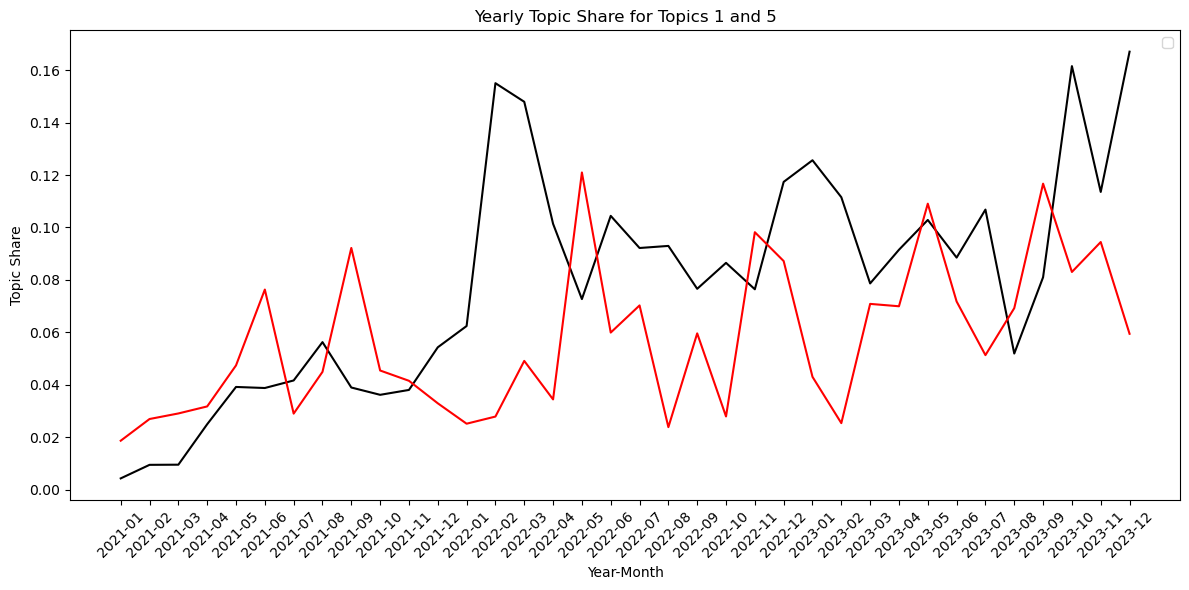

In [51]:
import matplotlib.pyplot as plt

# Convert 'year_month' Period objects to strings using .loc
result_df.loc[:, 'year_month'] = result_df['year_month'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))

# Plot each topic share over time within the filtered range
plt.plot(result_df['year_month'], result_df['topic_share_1'], color='black')
plt.plot(result_df['year_month'], result_df['topic_share_5'], color='red')



# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Yearly Topic Share for Topics 1 and 5')

plt.legend()

# Show plot
plt.tight_layout()
plt.show()


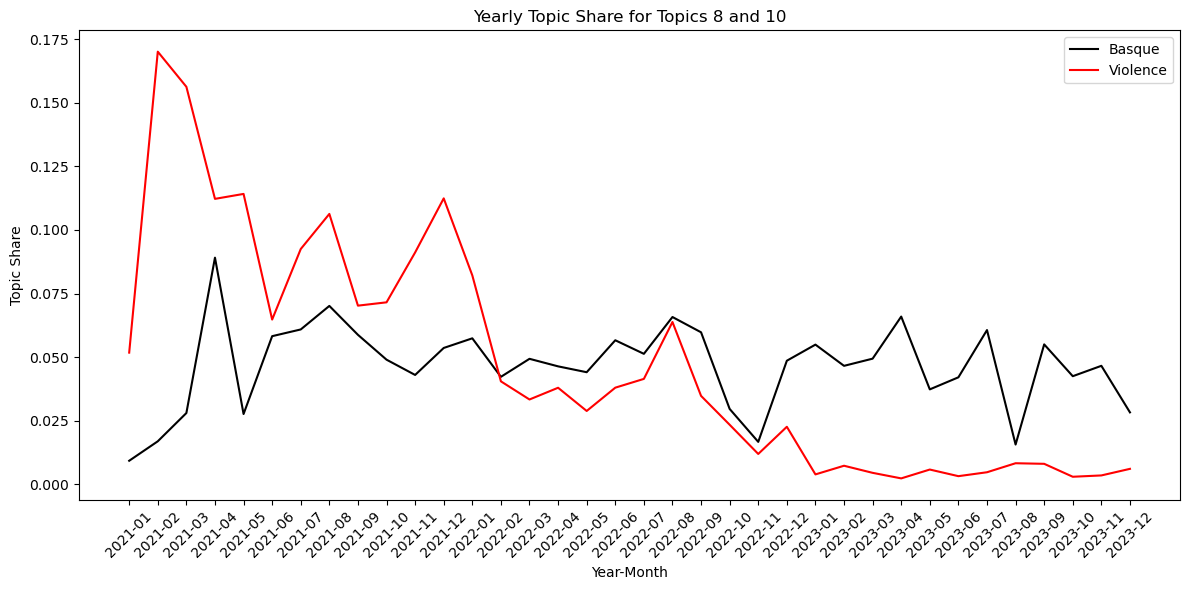

In [52]:
import matplotlib.pyplot as plt

# Convert 'year_month' Period objects to strings using .loc
result_df.loc[:, 'year_month'] = result_df['year_month'].astype(str)

# Plotting
plt.figure(figsize=(12, 6))

# Plot each topic share over time within the filtered range
plt.plot(result_df['year_month'], result_df['topic_share_8'], color='black')
plt.plot(result_df['year_month'], result_df['topic_share_10'], color='red')



# Rotate the x-axis tick labels for better readability
plt.xticks(rotation=45)

# Adding labels and title
plt.xlabel('Year-Month')
plt.ylabel('Topic Share')
plt.title('Yearly Topic Share for Topics 8 and 10')

plt.legend()

# Show plot
plt.tight_layout()
plt.show()


## 2. Here will be the TA_session

In [65]:
import pandas as pd
import numpy as np
import csv

import nltk
from nltk.stem import WordNetLemmatizer
from nltk.stem import SnowballStemmer 
from nltk.stem import PorterStemmer
from nltk.corpus import stopwords

import re
from matplotlib import pyplot as plt
from sklearn.feature_extraction.text import TfidfTransformer, CountVectorizer, TfidfVectorizer
from sklearn.decomposition import TruncatedSVD
import os
import re
from tqdm import tqdm
tqdm.pandas()
#getting a library of stopwords and defining a lemmatizer
porter=SnowballStemmer("english")
lmtzr = WordNetLemmatizer()

stop_words = set(stopwords.words('english'))

In [66]:
path="/Users/ruimaciel/Desktop/Barcelona/NLP_I/NLP-Project/"
filename ="data/thewhitehouse.csv"
WH_data = pd.read_csv(os.path.join(path, filename), sep=',', encoding='utf-8')
WH_data.head()

,Title,Date,Category,Location,Text
0,Remarks by President Biden and Vice President ...,2024-02-03T22:00:00-05:00,Speeches and Remarks,Biden for President Campaign Headquarters; Wil...,"THE VICE PRESIDENT: Hello, Delaware! (Applau..."
1,Remarks by Vice President Harris at a Campaign...,2024-02-02T23:33:00-05:00,Speeches and Remarks,"South Carolina State University; Orangeburg, S...",THE VICE PRESIDENT: All right. Can we hear i...
2,Remarks by President Biden at a Political Even...,2024-02-01T20:24:19-05:00,Speeches and Remarks,"Region 1 Union Hall; Warren, Michigan","4:41 P.M. EST\n \nTHE PRESIDENT: Well, thank ..."
3,Remarks by President Biden at the National Pra...,2024-02-01T14:13:03-05:00,Speeches and Remarks,"U.S. Capitol; Washington, D.C.","9:04 A.M. EST\nTHE PRESIDENT: Frank, thank yo..."
4,Remarks by President Biden at a Campaign Recep...,2024-01-31T00:04:32-05:00,Speeches and Remarks,"Private Residence; Miami, Florida","6:27 P.M. EST\n\nTHE PRESIDENT: Well, Chris, t..."


In [67]:
#I will not lemmatize as I will did it previously

In [68]:
#all hail the implementation of CV in sci-kit learn
cv = CountVectorizer(ngram_range = (1,2), lowercase=True, min_df=0.001, max_df=0.4, stop_words='english')
# we get bigrams and unigrams, we ignore words that appear in less than 0.1% of the documents and more than 40% of the documents

cv.fit(WH_data_lemma.Text)

vectorized_text=cv.transform(WH_data_lemma.Text)
vectorized_text=vectorized_text.toarray()
print("document term matrix has size", vectorized_text.shape)

document term matrix has size (7851, 116539)


In [69]:
#gensim needs the dtm in a different sparce format
dtm_sparse = csr_matrix(dtm)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items():
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_

In [72]:
# ILLUSTRATION: 
cv2 = CountVectorizer(ngram_range = (1,2), lowercase=True, stop_words='english')
# we get bigrams and unigrams, we ignore words that appear in less than 0.1% of the documents and more than 40% of the documents

cv2.fit(WH_data_lemma.Text[0:1])
vocabulary = cv2.get_feature_names_out()

print(WH_data_lemma.Text.iloc[0])  # Access the first element of 'Text' column using iloc[0]
print('\n\n')
print(vocabulary)


Effectively and equitably vaccinating the U.S. population will happen through stronger partnerships with states and communities, increased supply, more vaccination sites, and more vaccinators


The COVID-19 pandemic is getting worse by the day — more people are hospitalized with COVID-19 than ever before, the death rate is up almost 20 percent, and we’re nearing 400,000 deaths total. At the same time, there is a new, more contagious strain spreading across the country and we are woefully behind on vaccinating the U.S. population.


President-elect Biden will confront this historic challenge with the full strength of the federal government — working closely with local communities already in the trenches. He will lead an unprecedented, whole-of-society effort that mobilizes every resource available — across the public and private sectors. It will take every American doing their part.


As we move forward to get vaccines in arms as quickly as possible, we will not leave anyone behind. Com

In [74]:
print(WH_data_lemma.Text.iloc[0])  # Access the first element of 'Text' column using iloc[0]


Effectively and equitably vaccinating the U.S. population will happen through stronger partnerships with states and communities, increased supply, more vaccination sites, and more vaccinators


The COVID-19 pandemic is getting worse by the day — more people are hospitalized with COVID-19 than ever before, the death rate is up almost 20 percent, and we’re nearing 400,000 deaths total. At the same time, there is a new, more contagious strain spreading across the country and we are woefully behind on vaccinating the U.S. population.


President-elect Biden will confront this historic challenge with the full strength of the federal government — working closely with local communities already in the trenches. He will lead an unprecedented, whole-of-society effort that mobilizes every resource available — across the public and private sectors. It will take every American doing their part.


As we move forward to get vaccines in arms as quickly as possible, we will not leave anyone behind. Com

In [75]:
vectorized_title=cv.transform(WH_data_lemma.Text) # this uses the same vocabulary as the text
vectorized_title=vectorized_title.toarray()
print("document term matrix has size", vectorized_title.shape)
dtm=4*vectorized_title+vectorized_text # we give more weight to the title
print(type(dtm))

document term matrix has size (7851, 116539)
<class 'numpy.ndarray'>


In [76]:
from gensim import corpora, models
from gensim.matutils import Sparse2Corpus
from scipy.sparse import csr_matrix

#gensim needs the dtm in a different sparce format (from numpy to csr_matrix)
dtm_sparse = csr_matrix(dtm)

# Convert sparse matrix to gensim corpus
corpus = Sparse2Corpus(dtm_sparse, documents_columns=False)

# Create gensim dictionary from sklearn CountVectorizer vocabulary
vocabulary_gensim = {}
for key, val in cv.vocabulary_.items(): # remember cv has been fitted to the data
    vocabulary_gensim[val] = key

dictionary = corpora.Dictionary()
dictionary.id2token = vocabulary_gensim
dictionary.token2id = cv.vocabulary_


In [77]:
# Number of topics
num_topics = 10

# Build LDA model
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)

# Display the topics
topics = lda_model.print_topics(num_words=10)
for topic in topics:
    print(topic)

(0, '0.008*"know" + 0.005*"going" + 0.005*"plan" + 0.005*"ms" + 0.005*"border" + 0.004*"secretary" + 0.004*"think" + 0.003*"ll" + 0.003*"relief" + 0.003*"thank"')
(1, '0.018*"ms" + 0.018*"jean" + 0.018*"pierre" + 0.018*"jean pierre" + 0.018*"ms jean" + 0.016*"going" + 0.009*"know" + 0.006*"said" + 0.006*"right" + 0.005*"ahead"')
(2, '0.012*"going" + 0.009*"know" + 0.008*"ve" + 0.006*"applause" + 0.005*"jobs" + 0.005*"said" + 0.005*"think" + 0.004*"got" + 0.004*"thank" + 0.004*"look"')
(3, '0.009*"know" + 0.009*"applause" + 0.009*"thank" + 0.006*"vice president" + 0.006*"vice" + 0.005*"right" + 0.004*"nation" + 0.004*"women" + 0.004*"ve" + 0.003*"rights"')
(4, '0.007*"global" + 0.006*"countries" + 0.005*"climate" + 0.004*"international" + 0.004*"cooperation" + 0.004*"pacific" + 0.004*"energy" + 0.004*"partnership" + 0.003*"efforts" + 0.003*"commitment"')
(5, '0.009*"covid" + 0.007*"dr" + 0.007*"vaccine" + 0.006*"vaccinated" + 0.006*"19" + 0.006*"vaccines" + 0.006*"covid 19" + 0.005*"hea

In [78]:
#The goal here is to compare the SVD with the LDA.

from sklearn.decomposition import TruncatedSVD

# Apply SVD, we choose n_components = 2 for simplicity
svd = TruncatedSVD(n_components=10)
U = svd.fit_transform(dtm)
Sigma = svd.singular_values_
VT = svd.components_


terms = cv.get_feature_names_out()
for i, comp in enumerate(VT):
    terms_comp = zip(terms, comp)
    sorted_terms = sorted(terms_comp, key=lambda x: x[1], reverse=True)[:5]
    print("Topic " + str(i+1) + ": ", sorted_terms)

Topic 1:  [('ms', 0.3470274886196619), ('going', 0.3080679230543563), ('know', 0.28311547858846664), ('jean', 0.1712993018664893), ('pierre', 0.1712265825720772)]
Topic 2:  [('psaki', 0.4503568861962071), ('ms psaki', 0.4502426372475295), ('ms', 0.13812781154731998), ('jen', 0.06972054932183365), ('health', 0.05867206108810746)]
Topic 3:  [('health', 0.20134183426843763), ('applause', 0.13330901248941396), ('million', 0.13009706163942958), ('communities', 0.1276787786083441), ('care', 0.12348656025522839)]
Topic 4:  [('ms', 0.23677881726630526), ('pierre', 0.17938691844081234), ('jean', 0.17929410335847365), ('jean pierre', 0.17928368765651187), ('ms jean', 0.17925018313022772)]
Topic 5:  [('applause', 0.287171184450062), ('jobs', 0.1343039009528304), ('23', 0.12693235541406175), ('act', 0.1128942403685844), ('inflation', 0.10951697304014636)]
Topic 6:  [('climate', 0.19519118009890757), ('energy', 0.1942852691099474), ('ukraine', 0.16004135244012965), ('senior', 0.13839417505770968), 

In [79]:

import pyLDAvis
import pyLDAvis.gensim_models as gensimvis


vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis_data)


In [80]:
#This is to do coherence. It is purely mathematical so it may not be good.

from gensim.models.coherencemodel import CoherenceModel

cm = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
coherence = cm.get_coherence()  # get coherence value
coherence

-0.7000061640486692

In [43]:
#This took ages to run. As it is quite irrelevant, I would not run it again.


def compute_coherence(num_topics, corpus, dictionary):
    lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42)
    coherence_model = CoherenceModel(model=lda_model, corpus=corpus, coherence='u_mass')
    coherence = coherence_model.get_coherence()
    return coherence

coherence_values = []


min_topics = 2
max_topics = 10
step_size = 1

# Iterate over different numbers of topics
for num_topics in range(min_topics, max_topics + 1, step_size):
    coherence = compute_coherence(num_topics, corpus, dictionary)
    coherence_values.append(coherence)
    print(f"Number of Topics: {num_topics}, Coherence: {coherence}")

# Plotting coherence values vs. number of topics
import matplotlib.pyplot as plt

plt.plot(range(min_topics, max_topics + 1, step_size), coherence_values)
plt.xlabel("Number of Topics")
plt.ylabel("Coherence Score")
plt.title("Coherence vs. Number of Topics")
plt.xticks(range(min_topics, max_topics + 1, step_size))
plt.grid(True)
plt.show()

Number of Topics: 2, Coherence: -1.3763543754393361
Number of Topics: 3, Coherence: -1.7484346534998096
Number of Topics: 4, Coherence: -1.5046405685902813
Number of Topics: 5, Coherence: -1.7359650549689234
Number of Topics: 6, Coherence: -1.763363302375683
Number of Topics: 7, Coherence: -1.7521203580531481
Number of Topics: 8, Coherence: -1.0807986978098783
Number of Topics: 9, Coherence: -1.3054380033496542
Number of Topics: 10, Coherence: -1.0790670875382158


KeyboardInterrupt: 

In [81]:
#Here we do another LDA, but we change the alpha paramenter. There is a need to understand what is going here.


num_topics = 10
lda_model = models.LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics, passes=20, random_state=42,alpha=20)


lda_model.show_topics

vis_data = gensimvis.prepare(lda_model, corpus, dictionary)

pyLDAvis.display(vis_data)

In [ ]:
#Then we have guided LDA, lets not do it now.